In [1]:
%reload_ext autoreload
%autoreload 2
import os, sys
sys.path.append('..')

from tqdm import tqdm
import dill as pickle
import csv
import datetime
import warnings

import numpy as np
from scipy import integrate
from scipy.integrate import IntegrationWarning

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc_file('../matplotlibrc')

In [2]:
from utils.snr import *
from utils.spectral import *
from utils.nfw import rho_NFW

## 1. Download

In [3]:
! wget "http://snrcat.physics.umanitoba.ca/SNRdownload.php?table=SNR" -O ../data/SNR/SNRcat-SNR.csv
! wget "http://snrcat.physics.umanitoba.ca/SNRdownload.php?table=SNR" -O ../data/SNR/SNRcat-OBS.csv

--2023-04-26 14:49:16--  http://snrcat.physics.umanitoba.ca/SNRdownload.php?table=SNR
Resolving snrcat.physics.umanitoba.ca (snrcat.physics.umanitoba.ca)... 130.179.72.161
Connecting to snrcat.physics.umanitoba.ca (snrcat.physics.umanitoba.ca)|130.179.72.161|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘../data/SNR/SNRcat-SNR.csv’

    [ <=>                                   ] 49,473      --.-K/s   in 0.07s   

2023-04-26 14:49:16 (726 KB/s) - ‘../data/SNR/SNRcat-SNR.csv’ saved [49473]

--2023-04-26 14:49:17--  http://snrcat.physics.umanitoba.ca/SNRdownload.php?table=SNR
Resolving snrcat.physics.umanitoba.ca (snrcat.physics.umanitoba.ca)... 130.179.72.161
Connecting to snrcat.physics.umanitoba.ca (snrcat.physics.umanitoba.ca)|130.179.72.161|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘../data/SNR/SNRcat-OBS.csv’

    [ <=>                                   ] 49,4

In [6]:
# removed first 2 lines of the files
date_str = datetime.date.today().strftime("%Y%m%d")
for tag in ['SNR', 'OBS']:
    reader = csv.reader(open(f'../data/SNR/SNRcat-{tag}.csv', 'r'), delimiter=';')
    next(reader); next(reader)
    writer = csv.writer(open(f'../data/SNR/SNRcat{date_str}-{tag}_dehead.csv', 'w'), delimiter=';')
    writer.writerows(reader)

## 2. Filter valid SNR

### 2.1 Valid SNR from SNRcat
Requires SNR to have distance and age information.

In [16]:
date_str = '20230426'

In [17]:
snr_list = []
snr_valid_list = []

with open(f'../data/SNR/SNRcat{date_str}-SNR_dehead.csv', 'r') as csvf:
    csv_reader = csv.DictReader(csvf, delimiter=';')
    
    for i, row in enumerate(csv_reader):
        
        if row['G'] == 'G358.1+00.1':
            row['G'] = 'G358.1+01.0' # error in SNRcat
        print(f"{i}: {row['G']}", end='\r', flush=True)
        
        d_min = row['distance_min (kpc)'] # must have dist min & max
        d_max = row['distance_max (kpc)']
        t_now_min = row['age_min (yr)'] # must have age min & max
        t_now_max = row['age_max (yr)']
        
        if d_min != '' and d_max != '':
            d = np.sqrt( float(d_min) * float(d_max) )
        else:
            d = None
            
        if t_now_min != '' and t_now_max != '':
            t_now = np.sqrt( float(t_now_min) * float(t_now_max) )
        else:
            t_now = None
        
        snr = SNR(
            ID = row['G'],
            name_alt = row['id_alt'],
            snr_type = row['type'],
            l = float(row['G'][1:6]) * deg,
            b = float(row['G'][6:11]) * deg,
            size = float(row['size_coarse (arcmin)']) * arcmin,
            d = d,
            t_now = t_now,
            snrcat_dict = row
        )
        # Additional information
        if snr.d is not None:
            snr.d_min = float(d_min)
            snr.d_max = float(d_max)
        if snr.t_now is not None:
            snr.t_now_min = float(t_now_min)
            snr.t_now_max = float(t_now_max)
        
        snr_list.append(snr)
        if d is not None and t_now is not None:
            snr_valid_list.append(snr)

### 2.2 Valid SNR from Green's catalog
Requires SNR to have flux information. Copy [this page](https://www.mrao.cam.ac.uk/surveys/snrs/snrs.data.html) to `../data/SNR/Green.txt`

In [18]:
snr_valid_SG_list = []
varied_str = ''
cant_find_str = ''

with open('../data/SNR/Green.txt') as f:
    lines = f.readlines()
    for i, line in enumerate(lines[4:]):
        line_strs = list(filter(None,line.split(' ')))
        green_dict = {}
        green_dict['ID'] = GID(line_strs[0], line_strs[1])
        green_dict['name_oth'] = '' if len(line_strs)<=11 else ' '.join(line_strs[11:]).replace('\n', '')
        green_dict['size_str'] = line_strs[7]
        green_dict['type'] = line_strs[8]
        green_dict['Snu1GHz'] = line_strs[9]
        green_dict['spec_ind'] = line_strs[10].replace('\n', '')
        
        snr       = get_snr(green_dict['ID'], snr_list)
        snr_valid = get_snr(green_dict['ID'], snr_valid_list)
        
        if snr is None:
            print('X', end='')
            cant_find_str += green_dict['ID'] + ' '
            continue
        if snr_valid is None:
            print('_', end='')
            continue
        
        Snu1GHz_str = green_dict['Snu1GHz'].replace('?','').replace('>','')
        if Snu1GHz_str == '':
            continue
        snr.Snu1GHz = float(Snu1GHz_str)
        
        si_str = green_dict['spec_ind'].replace('?','')
        if si_str == '':
            continue
        try:
            snr.si = float(si_str)
        except ValueError:
            snr.si = si_str
            varied_str += green_dict['ID']+' '+green_dict['spec_ind']+' '+green_dict['name_oth']+'\n'
        
        snr.green_dict = green_dict
            
        snr_valid_SG_list.append(snr)
        print('O', end='')
        
    if cant_find_str == '':
        cant_find_str = 'None.'
    print('\ncan\'t find: '+cant_find_str)
    print(varied_str)
    
print(f'Total valid SNR: {len(snr_valid_SG_list)}')

O_O__O___________O____O__O_________O____________OO___O____O_OO___O_O_O_O_O__O___O___O_OOO__OO_O___O__OOOOOO__O___OOO__O__O__OOO_OO_OO__O___OO_OOOO_OO_O__O_OO__O_O_O_OO_O_OOO_O__OOOO__OOOO_____OO__O___O___O_____O_____O_O____O__OOO__OO_O__________O_O_OO_O______O_________O___OO_
can't find: None.
G000.9+00.1 varies 
G006.4-00.1 varies W28
G021.5-00.9 varies 
G031.9+00.0 varies 3C391
G065.7+01.2 varies DA 495
G069.0+02.7 varies CTB 80
G074.0-08.5 varies Cygnus Loop
G074.9+01.2 varies CTB 87
G180.0-01.7 varies S147
G263.9-03.3 varies Vela (XYZ)
G326.3-01.8 varies MSH 15-56

Total valid SNR: 102


In [19]:
pickle.dump(snr_valid_SG_list, open('../data/SNR/prebuild_snrlist.p', 'wb'))

## 3. Build SNR with fiducial values and variations

In [8]:
variation_flags = ['none', 'tiop1', 'tMFA_p', 'tMFA_m', 'd_p', 'd_m', 'age_p', 'age_m']

In [20]:
warnings.filterwarnings('ignore', category=IntegrationWarning)

for vflag in variation_flags[4:]:
    
    print(vflag, ':')
    snr_valid_SG_list = pickle.load(open('../data/SNR/prebuild_snrlist.p', 'rb'))
    
    #===== general snr =====
    for snr in snr_valid_SG_list:
        if isinstance(snr.si, str):
            snr.si = 0.5
            snr.si_guessed = True
        else:
            snr.si_guessed = False
        snr.t_free = 500 # [yr]
        if vflag == 'tMFA_p':
            snr.t_MFA = 300 # [yr]
        elif vflag == 'tMFA_m':
            snr.t_MFA = 30 # [yr]
        else:
            snr.t_MFA = 100 # [yr]
            
        # Adjust d and age
        if vflag == 'd_p':
            snr.d = snr.d_max
        elif vflag == 'd_m':
            snr.d = snr.d_min
            
        if vflag == 'age_p':
            snr.t_now = snr.t_now_max
        elif vflag == 'age_m':
            snr.t_now = snr.t_now_min
        
    #===== individual changes =====
    snr = get_snr('G263.9-03.3', snr_valid_SG_list)
    snr.name_alt = 'Vela'
    snr.si = (2.47-1)/2 # fiducial: 2.47
    snr.t_now = 12000 # fiducial: 10000-12000-14000
    if vflag == 'age_p':
        snr.t_now = 14000
    elif vflag == 'age_m':
        snr.t_now = 10000
    snr.d = 0.287 # kpc
    if vflag == 'd_p':
        snr.d = 0.287 + 0.019
    if vflag == 'd_m':
        snr.d = 0.287 - 0.017
    snr.Snu1GHz = 670

    snr = get_snr('G006.4-00.1', snr_valid_SG_list)
    snr.name_alt = 'W28'
    snr.si = 0.42 # Kassim 1992 | 330 MHz VLA OBSERVATIONS OF 20 GALACTIC SUPERNOVA REMNANTS
    # density # https://arxiv.org/pdf/1805.03372.pdf, Reach et al 2005
    snr.t_now = 34467 # yr
    if vflag == 'age_p':
        snr.t_now = 100000
    elif vflag == 'age_m':
        snr.t_now = 30000
    snr.d = 1.876 # kpc
    if vflag == 'd_p':
        snr.d = 1.6
    if vflag == 'd_m':
        snr.d = 2.2

    snr = get_snr('G039.7-02.0', snr_valid_SG_list)
    snr.name_alt = 'W50'
    snr.t_now = 54772 # fiducial: 30000-54772-100000
    if vflag == 'age_p':
        snr.t_now = 100000
    elif vflag == 'age_m':
        snr.t_now = 30000
    snr.d = 4.77 # kpc
    if vflag == 'd_p':
        snr.d = 3.5
    if vflag == 'd_m':
        snr.d = 6.5
    snr.si = 0.7 # fiducial: 0.7

    snr = get_snr('G326.3-01.8', snr_valid_SG_list)
    snr.name_alt = 'MSH 15-56'
    snr.si = 0.34 # RADIO EMISSION FROM THE COMPOSITE SUPERNOVA REMNANT G326.3-1.8 (MSH 15-56)
    
    #===== build =====
    if vflag == 'tiop1':
        tiop = '1'
    else:
        tiop = '2'
    for snr in tqdm(snr_valid_SG_list):
        snr.build(rho_DM=rho_NFW, tiop=tiop)
        
    #===== save =====
    pickle.dump(snr_valid_SG_list, open(f'../data/SNR/snrlist_{vflag}.p', 'wb'))

d_p :


100%|█████████████████████████████████████████████████████████████████████████████| 102/102 [02:59<00:00,  1.76s/it]


d_m :


100%|█████████████████████████████████████████████████████████████████████████████| 102/102 [02:59<00:00,  1.76s/it]


age_p :


100%|█████████████████████████████████████████████████████████████████████████████| 102/102 [03:13<00:00,  1.89s/it]


age_m :


100%|█████████████████████████████████████████████████████████████████████████████| 102/102 [02:38<00:00,  1.55s/it]


## Check

In [20]:
a = pickle.load(open(f'../data/SNR/snrlist.p', 'rb'))
b = pickle.load(open(f'../data/SNR/snrlist_none.p', 'rb'))

In [25]:
for sa, sb in zip(a, b):
    print((sa.image_sigma_fg- sb.image_sigma_fg)/sa.image_sigma_fg)

0.500885621166035
2.177497162520584e-05
-3.490578893121527e-05
8.08321996262222e-09
4.049186852664953e-06
-3.5738279386853174e-08
4.5067091468635276e-06
1.0972249322015124e-06
3.75310786517587e-06
4.264350831026862e-06
-6.082584591750373e-08
2.4200599659013326e-08
3.079608941397334e-07
1.4696716367222188e-05
3.617772656540522e-08
2.2770792035511104e-08
6.174876428193226e-06
2.7943495109827606e-06
1.4036446530878358e-05
2.288435696208322e-08
-6.11108336750402e-08
9.293864840856424e-07
5.5230097391785296e-08
3.9713771711382296e-07
-1.2812527140487245e-07
3.511309665125148e-08
-1.6976386181395234e-06
1.0205546933544133e-06
6.929882741189988e-08
-6.177902972279775e-09
0.0014852523461517985
1.3106439664055343e-08
-9.50366732023932e-06
4.979650003421187e-10
-1.5672902217084191e-07
3.770047623113282e-08
7.346343021461398e-09
-3.2056659308436395e-09
7.767907905696189e-06
2.2341697893055416e-08
1.7207056211123576e-07
-4.55964021484703e-08
8.107943667467483e-08
5.0236977135744777e-08
7.925087185

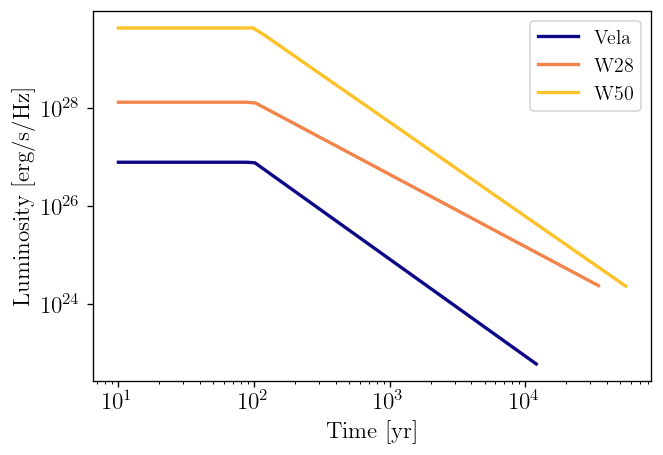

In [26]:
# plot Vela, W28 W50
fig, ax = plt.subplots()

colors = [ plt.get_cmap('plasma')(x) for x in [0.0, 0.7, 0.87] ]

for i, name in enumerate(['Vela', 'W28', 'W50']):
    snr = get_snr(name, snr_valid_SG_list)
    t_s = np.logspace(np.log10(10), np.log10(snr.t_now), 50) # [yr]
    L_s = [4*np.pi * (snr.d*kpc)**2 * 1e-23 * snr.Snu_t_fl(1000, t, tiop='2') for t in t_s]
    ax.plot(t_s, L_s, label=name, color=colors[i], lw=2)
ax.set(xscale='log', yscale='log')
ax.set(xlabel='Time [yr]', ylabel='Luminosity [erg/s/Hz]')
ax.legend();

In [32]:
# expected gegenschein flux
get_snr('Vela', snr_valid_SG_list).Sgnu(1000)

5.211845831087532e-05